# Unblind Normalisation Decay Mode
Models have now been retrained in the normalisation mode. These models have also been evaluated such that a predicted performance has been estimated. We now test this performance by unblinding these data.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import zfit
from zfit import z
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

2022-04-30 10:51:57.155110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-30 10:51:57.155150: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


## Load Data
This is more sophisticated than usual due to the way create_data works. We cannot use any simulated data, obviously since we are now doing an unblinded analysis. Further we only want to use data from the blinded region (we have not observed this before) along with the test data from the sidebands. 

In [2]:
# All the events in this sample will have been unseen before due to the constant random seeds
# also does not include a blind, other event data are normalised
df = pd.read_csv('../data_files/8.0.6/test.csv', index_col=[0])

# Only keep events which are not simulated also the Q^2 veto has already been applied
df_nosim = df[df['IsSimulated']==False].copy()

## Visual Inspection
This is a well known decay and the $J/\psi$ resonance is strong so should be easily observed by eye. The machine learning algorithms should only be used to refine this search even more.

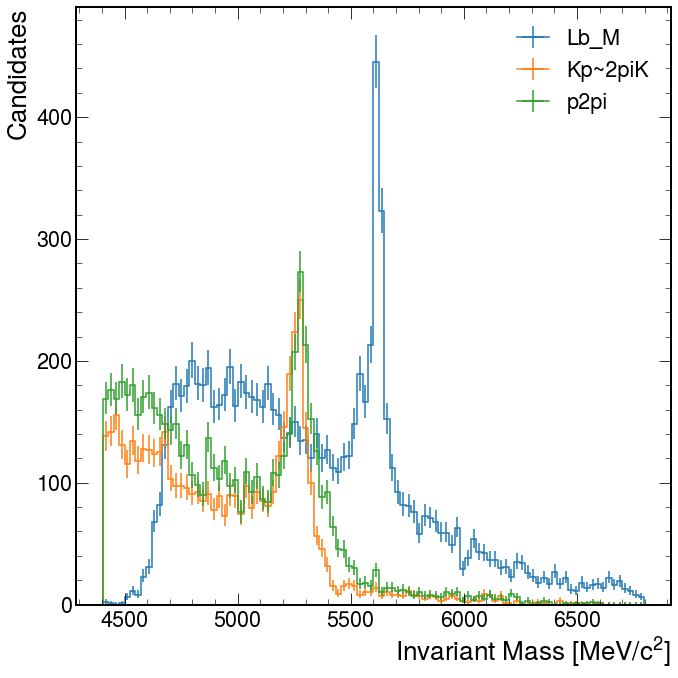

In [3]:
fig, ax = plt.subplots(1, 1)
h, bins = np.histogram(df_nosim['Lb_M'], bins=100)
h1, _ = np.histogram(df_nosim['Lb_M0123_Subst01_Kp~2piK'], bins=bins)
h2, _ = np.histogram(df_nosim['Lb_M0123_Subst0_p2pi'], bins=bins)
hep.histplot([h, h1, h2], bins=bins, yerr=True, ax=ax, label=['Lb_M', 'Kp~2piK', 'p2pi'])
plt.xlabel(r'Invariant Mass [$MeV/c^2$]')
plt.ylabel('Candidates')
plt.legend()
plt.tight_layout()
plt.show()

## Apply Neural Network
Now we need to load the neural network that has been tuned to the normalisation mode and then apply this to generate predictions. Recall that the Punzi optimised cut threshold was $p_{thr}=0.8$.

In [4]:
model = tf.keras.models.load_model('../model_evaluation/models/NN_8.0.5')

2022-04-30 10:52:09.769937: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-30 10:52:09.769984: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-30 10:52:09.770030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eprexb.ph.bham.ac.uk): /proc/driver/nvidia/version does not exist
2022-04-30 10:52:09.770373: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
predictions = model.predict(df_nosim.drop(['Lb_M', 'category', 'QSQR', 'IsSimulated', 'Lb_M0123_Subst01_Kp~2piK', 'Lb_M0123_Subst0_p2pi'], axis=1))
predicted_classes = np.where(predictions > 0.7, 1, 0)
df_nosim['PredictedClass'] = predicted_classes

2022-04-30 10:52:12.587334: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Plot Results
The big reveal here goes!

/tmp/ipykernel_1594210/3364633498.py:8: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].scatter([np.mean(bins[i:i+2]) for i in range(len(bins)-1)], ((h1-h)/h), marker='x')


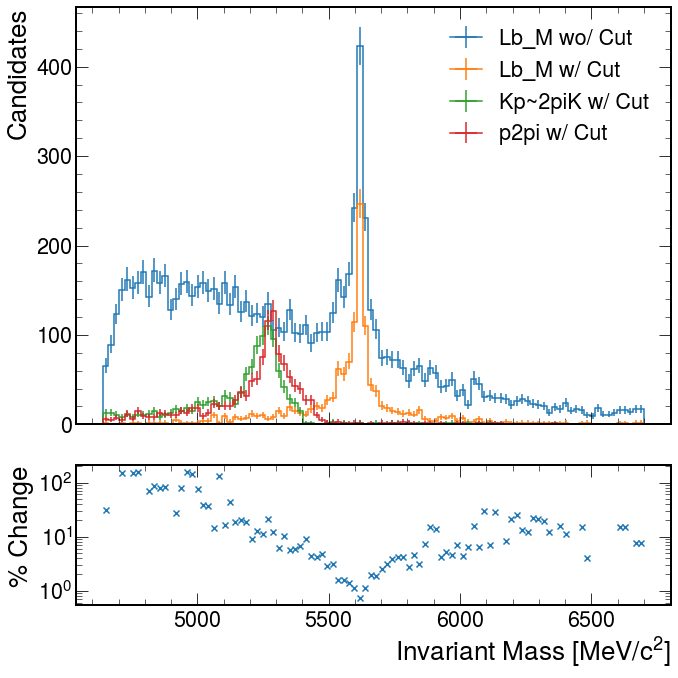

In [6]:
fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1]})
h, bins = np.histogram(df_nosim['Lb_M'][df_nosim['PredictedClass']==1], bins=100)
h2, _ = np.histogram(df_nosim['Lb_M0123_Subst01_Kp~2piK'][df_nosim['PredictedClass']==1], bins=bins)
h3, _ = np.histogram(df_nosim['Lb_M0123_Subst0_p2pi'][df_nosim['PredictedClass']==1], bins=bins)
h1, _ = np.histogram(df_nosim['Lb_M'], bins=bins)
hep.histplot([h1, h, h2, h3], bins=bins, yerr=True, ax=ax[0], label=['Lb_M wo/ Cut', 'Lb_M w/ Cut', 'Kp~2piK w/ Cut', 'p2pi w/ Cut'])
plt.xlabel(r'Invariant Mass [$MeV/c^2$]')
ax[1].scatter([np.mean(bins[i:i+2]) for i in range(len(bins)-1)], ((h1-h)/h), marker='x')
ax[0].set_ylabel('Candidates')
ax[1].set_ylabel('% Change')
ax[0].legend()
ax[1].set_yscale('log')
plt.tight_layout()
#plt.savefig('../images/Normalisation/Unblind_Pre_Post_Cut_AllMasses.png')
plt.show()

In [7]:
df_nosim['PredictedClass'][df_nosim['Lb_M'].between(5200, 5800)].value_counts()

0    2672
1    1058
Name: PredictedClass, dtype: int64

## Fitting Residual Data
Now we have applied a cut and have our residual data (that looks very promising) we need to a fit a function to this. Specifically the sum of our original background and signal fits in this mode i.e. cubic + DCB. 

In [7]:
class MyLinear(zfit.pdf.ZPDF):
   _PARAMS = ['p0', 'p1', 'shift']
   
   def _unnormalized_pdf(self, x):
      x = z.unstack_x(x)
      p0 = self.params['p0']
      p1 = self.params['p1']
      shift = self.params['shift']
      return (p1 * (x-shift)) + p0

class MyCubic(zfit.pdf.ZPDF):
    _PARAMS = ['p0', 'p1', 'p2', 'p3', 'shift']

    def _unnormalized_pdf(self, x):
       x = z.unstack_x(x)
       p0 = self.params['p0']
       p1 = self.params['p1']
       p2 = self.params['p2']
       p3 = self.params['p3']
       shift = self.params['shift']
       return (p3*(x-shift))**3 + (p2*(x-shift))**2 + p1*(x-shift) + p0

def CubicIntegral(limits, params, model):
   (lower,), (upper,) = limits.limits
   p0 = params['p0']
   p1 = params['p1']
   p2 = params['p2']
   p3 = params['p3']
   shift = params['shift']
   ll = (p3/4)*(p3*(lower-shift))**4 + (p2/3)*(lower-shift)**3 + (p1/2)*(lower-shift)**2 + p0*lower
   ul = (p3/4)*(upper-shift)**4 + (p2/3)*(upper-shift)**3 + (p1/2)*(upper-shift)**2 + p0*upper   
   return ul - ll

def LinearIntegral(limits, params, model):
   (lower,), (upper,) = limits.limits
   p0 = params['p0']
   p1 = params['p1']
   shift = params['shift']
   ll = (p0 * lower) + (p1/2)*((lower-shift)**2)
   ul = (p0 * upper) + (p1/2)*((upper-shift)**2) 
   return ul - ll

limits = zfit.Space.from_axes(axes=0, limits=(zfit.Space.ANY_LOWER, zfit.Space.ANY_UPPER))
MyCubic.register_analytic_integral(func=CubicIntegral, limits=limits)
MyLinear.register_analytic_integral(func=LinearIntegral, limits=limits)

In [8]:
def fitDCBLinear(np_data, label, param_ranges, mass_ranges=[4750, 6500]):
    
    # Create a space for the observations
    massObs = zfit.Space("Lb_M", limits=(mass_ranges[0], mass_ranges[1]))
    LbM = zfit.Data.from_numpy(obs=massObs, array=np_data)
    
    # Define all the parameters for the DCB
    mu_CB = zfit.Parameter('mu_CB_%s'%label, 5621.166132204511, 5600, 5650)
    sigma_CB = zfit.Parameter('sigma_CB_%s'%label, 14.290431757231055, 5, 35)
    alpha_l = zfit.Parameter('alpha_l_%s'%label, 1.5297914213799109, 0, 5)
    n_l = zfit.Parameter('n_l_%s'%label, 2.229162455844571, 0, 5)
    alpha_r = zfit.Parameter('alpha_r_%s'%label, 1.9740604518420264, 0, 5)
    n_r = zfit.Parameter('n_r_%s'%label, 4.0853679095372195, 0, 10)
    
    # Define all the cubic parameters
    p1 = zfit.Parameter('p1_%s'%label, 0, -5, 5)
    p0 = zfit.Parameter('p0_%s'%label, 5, 0, 50)
    shift = zfit.Parameter('shift_%s'%label, 5000, 4000, 6500)
    
    # Model building and pdf creation
    dcb = zfit.pdf.DoubleCB(obs=massObs, mu=mu_CB, sigma=sigma_CB, alphal=alpha_l, nl=n_l, alphar=alpha_r, nr=n_r)
    linear = MyLinear(obs=massObs, p0=p0, p1=p1, shift=shift)
    
    # Number of event yield parameters
    n_bkg = zfit.Parameter('n_bkg_%s'%label, *param_ranges[0])
    n_sig = zfit.Parameter('n_sig_%s'%label, *param_ranges[1])
    
    # Extended models
    dcb_ext = dcb.create_extended(n_sig)
    linear_ext = linear.create_extended(n_bkg)
    model = zfit.pdf.SumPDF([dcb_ext, linear_ext])
    
    nll = zfit.loss.ExtendedUnbinnedNLL(model=model, data=LbM)
    
    # Create a minimizer
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    
    return model, result, LbM

In [9]:
def fitDCBCubic(np_data, label, param_ranges, mass_ranges=[4750, 6500]):
    
    # Create a space for the observations
    massObs = zfit.Space("Lb_M", limits=(mass_ranges[0], mass_ranges[1]))
    LbM = zfit.Data.from_numpy(obs=massObs, array=np_data)
    
    # Define all the parameters for the DCB
    mu_CB = zfit.Parameter('mu_CB_%s'%label, 5621.166132204511, 5600, 5650)
    sigma_CB = zfit.Parameter('sigma_CB_%s'%label, 14.290431757231055, 5, 35)
    alpha_l = zfit.Parameter('alpha_l_%s'%label, 1.5297914213799109, 0, 5)
    n_l = zfit.Parameter('n_l_%s'%label, 2.229162455844571, 0, 5)
    alpha_r = zfit.Parameter('alpha_r_%s'%label, 1.9740604518420264, 0, 5)
    n_r = zfit.Parameter('n_r_%s'%label, 4.0853679095372195, 0, 10)
    
    # Define all the cubic parameters
    p3 = zfit.Parameter('p3_%s'%label, 0.00727449281937842, 0, 1)
    p2 = zfit.Parameter('p2_%s'%label, 0.040733554821436924, 0, 1)
    p1 = zfit.Parameter('p1_%s'%label, 1.6537098715534306, 0, 3)
    p0 = zfit.Parameter('p0_%s'%label, 598.2285853167873, 0, 620)
    shift = zfit.Parameter('shift_%s'%label, 7014.1855396674655, 6000, 7500)
    
    # Model building and pdf creation
    dcb = zfit.pdf.DoubleCB(obs=massObs, mu=mu_CB, sigma=sigma_CB, alphal=alpha_l, nl=n_l, alphar=alpha_r, nr=n_r)
    cubic = MyCubic(obs=massObs, p0=p0, p1=p1, p2=p2, p3=p3, shift=shift)
    
    # Number of event yield parameters
    n_bkg = zfit.Parameter('n_bkg_%s'%label, *param_ranges[0])
    n_sig = zfit.Parameter('n_sig_%s'%label, *param_ranges[1])
    
    # Extended models
    dcb_ext = dcb.create_extended(n_sig)
    cubic_ext = cubic.create_extended(n_bkg)
    model = zfit.pdf.SumPDF([dcb_ext, cubic_ext])
    
    nll = zfit.loss.ExtendedUnbinnedNLL(model=model, data=LbM)
    
    # Create a minimizer
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll, params=[n_bkg, n_sig])
    
    return model, result, LbM

In [10]:
def fitDCB(np_data, label, param_ranges, mass_ranges=[4750, 6500]):
    
    # Create a space for the observations
    massObs = zfit.Space("Lb_M", limits=(mass_ranges[0], mass_ranges[1]))
    LbM = zfit.Data.from_numpy(obs=massObs, array=np_data)
    
    # Define all the parameters for the DCB
    mu_CB = zfit.Parameter('mu_CB_%s'%label, 5621.166132204511, 5600, 5650)
    sigma_CB = zfit.Parameter('sigma_CB_%s'%label, 14.290431757231055, 5, 35)
    alpha_l = zfit.Parameter('alpha_l_%s'%label, 1.5297914213799109, 0, 5)
    n_l = zfit.Parameter('n_l_%s'%label, 2.229162455844571, 0, 5)
    alpha_r = zfit.Parameter('alpha_r_%s'%label, 1.9740604518420264, 0, 5)
    n_r = zfit.Parameter('n_r_%s'%label, 4.0853679095372195, 0, 10)
    
    # Model building and pdf creation
    dcb = zfit.pdf.DoubleCB(obs=massObs, mu=mu_CB, sigma=sigma_CB, alphal=alpha_l, nl=n_l, alphar=alpha_r, nr=n_r)
    
    # Number of event yield parameters
    n_sig = zfit.Parameter('n_sig_%s'%label, *param_ranges[1])
    
    # Extended models
    dcb_ext = dcb.create_extended(n_sig)
    
    nll = zfit.loss.ExtendedUnbinnedNLL(model=dcb_ext, data=LbM)
    
    # Create a minimizer
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    
    return dcb_ext, result, LbM

In [11]:
def fitDCBGauss(np_data, label, param_ranges, mass_ranges=[4750, 6500]):
    
    # Create a space for the observations
    massObs = zfit.Space("Lb_M", limits=(mass_ranges[0], mass_ranges[1]))
    LbM = zfit.Data.from_numpy(obs=massObs, array=np_data)
    
    # Define all the parameters for the DCB
    mu_CB = zfit.Parameter('mu_CB_%s'%label, 5621.166132204511, 5600, 5650)
    sigma_CB = zfit.Parameter('sigma_CB_%s'%label, 14.290431757231055, 5, 35)
    alpha_l = zfit.Parameter('alpha_l_%s'%label, 1.5297914213799109, 0, 5)
    n_l = zfit.Parameter('n_l_%s'%label, 2.229162455844571, 0, 5)
    alpha_r = zfit.Parameter('alpha_r_%s'%label, 1.9740604518420264, 0, 5)
    n_r = zfit.Parameter('n_r_%s'%label, 4.0853679095372195, 0, 10)
    
    mu_G = zfit.Parameter('mu_G%s'%label, 5600, 5200, 6000)
    sigma_G = zfit.Parameter('sigma_G%s'%label, 300, 10, 700)
    
    # Model building and pdf creation
    dcb = zfit.pdf.DoubleCB(obs=massObs, mu=mu_CB, sigma=sigma_CB, alphal=alpha_l, nl=n_l, alphar=alpha_r, nr=n_r)
    gauss = zfit.pdf.Gauss(obs=massObs, mu=mu_G, sigma=sigma_G)
    
    # Number of event yield parameters
    n_sig = zfit.Parameter('n_sig_%s'%label, *param_ranges[1])
    n_bkg = zfit.Parameter('n_bkg_%s'%label, *param_ranges[0])
    
    # Extended models
    dcb_ext = dcb.create_extended(n_sig)
    gauss_ext = gauss.create_extended(n_bkg)
    model = zfit.pdf.SumPDF([dcb_ext, gauss_ext])
    
    nll = zfit.loss.ExtendedUnbinnedNLL(model=model, data=LbM)
    
    # Create a minimizer
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    
    return model, result, LbM, massObs

In [12]:
np_data = np.squeeze(df_nosim['Lb_M'][df_nosim['PredictedClass']==1].to_numpy())

In [13]:
param_ranges = [[0, -10000, 30000], [1000, 0, 35000]]
model, result, masses, obs = fitDCBGauss(np_data, '1', param_ranges)
print(result.converged, result.valid)

if result.converged and result.valid:
    result.errors()
    print(result.params)

# fitDCB works fine with param_ranges = [[0, -10000, 30000], [1000, 0, 35000]]
# fitDCBLinear ---> Converged but NOT valid
# fitDCBCubic ---> Converged & Valid

True True


/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/minimizers/fitresult.py:1115: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


name          value         minuit_minos    at limit
----------  -------  -------------------  ----------
n_sig_1       876.2  -     75   +     78       False
n_bkg_1       379.7  -     73   +     72       False
alpha_l_1    0.3437  -   0.15   +   0.29       False
alpha_r_1    0.8574  -    0.3   +   0.39       False
mu_CB_1        5623  -    2.7   +    2.1       False
n_l_1         2.171  -   0.56   +    1.1       False
n_r_1         1.345  -   0.18   +   0.24       False
sigma_CB_1    7.728  -    1.2   +    5.2       False
mu_G1          5520  -     40   +     48       False
sigma_G1      298.1  -     24   +     24       False


In [28]:
result.params['n_bkg_1']

{'value': 379.7326593259202,
 'minuit_minos': {'lower': -73.48056422155948,
  'upper': 72.3831042823461,
  'is_valid': True,
  'upper_valid': True,
  'lower_valid': True,
  'at_lower_limit': False,
  'at_upper_limit': False,
  'nfcn': 389,
  'original': ┌──────────┬───────────────────────┐
│          │        n_bkg_1        │
├──────────┼───────────┬───────────┤
│  Error   │    -70    │    70     │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘,
  'cl': 0.68268949}}

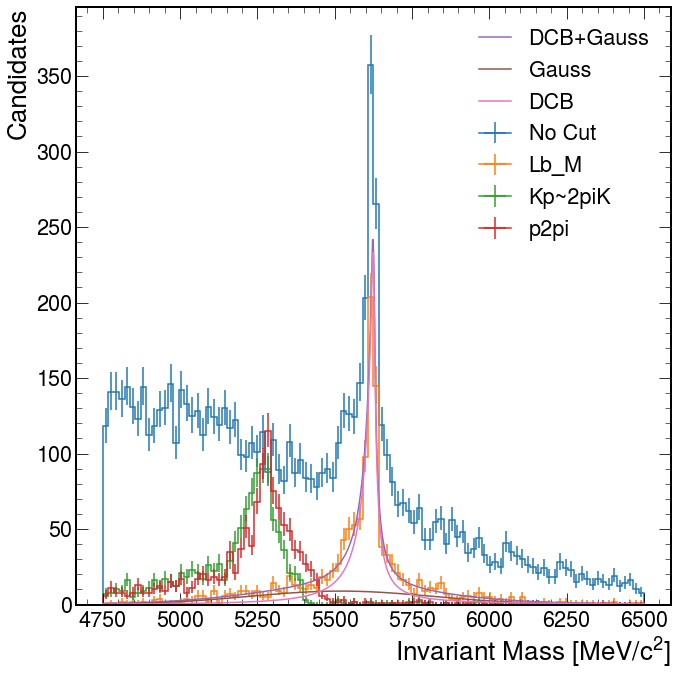

In [26]:
fig, ax = plt.subplots(1, 1)

lower, upper = 4750, 6500
data_np = zfit.run(masses.value()[:,0])

# Plot these data as a histogram
bins = 100
counts, bin_edges = np.histogram(data_np, bins, range=(lower, upper))
countsO, _ = np.histogram(df_nosim['Lb_M'], bins=bin_edges)
counts2, _ = np.histogram(np.squeeze(df_nosim['Lb_M0123_Subst01_Kp~2piK'][df_nosim['PredictedClass']==1].to_numpy()), bins=bin_edges)
counts3, _ = np.histogram(np.squeeze(df_nosim['Lb_M0123_Subst0_p2pi'][df_nosim['PredictedClass']==1].to_numpy()), bins=bin_edges)
hep.histplot([countsO, counts, counts2, counts3], bins=bin_edges, yerr=True, histtype='step', label=['No Cut', 'Lb_M', 'Kp~2piK', 'p2pi'])

# Evaluate the function(s) and plot them
x_plot = np.linspace(lower, upper, num=1000)
y_plot = zfit.run(model.pdf(x_plot, norm_range=obs)) * data_np.shape[0]/bins * obs.area()
ax.plot(x_plot, y_plot, label='DCB+Gauss')

composite_y = np.array(y_plot)

# Evaluate the single-functions and plot them
gauss = zfit.pdf.Gauss(obs=obs, mu=result.params['mu_G1']['value'],
                       sigma=result.params['sigma_G1']['value'])
y2_plot = np.array(zfit.run(gauss.pdf(x_plot, norm_range=obs)) * data_np.shape[0]/bins * obs.area())

dcb = zfit.pdf.DoubleCB(obs=obs, mu=result.params['mu_CB_1']['value'],
                        sigma=result.params['sigma_CB_1']['value'],
                        alphal=result.params['alpha_l_1']['value'],
                        nl=result.params['n_l_1']['value'],
                        alphar=result.params['alpha_r_1']['value'],
                        nr=result.params['n_r_1']['value'])
y3_plot = np.array(zfit.run(dcb.pdf(x_plot, norm_range=obs)) * data_np.shape[0]/bins * obs.area())

fracs_total = result.params["n_bkg_1"]['value'] + result.params["n_sig_1"]['value']
y2_plot_scaled = y2_plot * result.params["n_bkg_1"]['value'] / fracs_total
y3_plot_scaled = y3_plot * result.params["n_sig_1"]['value'] / fracs_total

ax.plot(x_plot, y2_plot_scaled, label='Gauss')
ax.plot(x_plot, y3_plot_scaled, label='DCB')

plt.xlabel(r'Invariant Mass [$MeV/c^2$]')
plt.ylabel('Candidates')
plt.legend()
plt.tight_layout()
plt.savefig('../images/Normalisation/Unblinded_PostCut_AllFits_withMassSwap_PreMass.png')
plt.show()

# Yield & Yield Error

In [29]:
# Integrate the 'raw' function
nsignal = dcb.integrate(limits=(4750, 6500), norm_range=obs.limits)